# Where, O, Where Do The College Grads Go?
As early career professionals, graduating students have curiousity about where they may want to move. Where they want is only part of the conversation. In this project, we explore the relationship between city based livable wages and salary data from a set of majors. 

## Data preprocessing
These dataframes will be used throughout the rest of this notebook.

In [1]:
from pathlib import Path 
home = str(Path.home()) # all other paths are relative to this path. change to something else if this is not the case on your system

In [2]:
%load_ext autoreload
%autoreload 2

# make sure your run the cell above before running this
import Project_helper

In [3]:
# Package imports
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [4]:
cities = pd.read_csv(f'./livingwage.csv') # you might need to change this path
cities = cities.dropna()
cities.head()

,rank_2020,city,state,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage
0,1,New York,New York,8804190,8175133,300.5,29298,20.00,38.99,49.18,64.30,29.16,34.35,38.13,42.42,14.03,20.95,26.53,32.40
1,2,Los Angeles,California,3898747,3792621,469.5,8304,19.22,41.55,51.30,67.56,31.01,37.96,41.94,47.75,14.62,22.36,27.73,34.01
2,3,Chicago,Illinois,2746388,2695598,227.7,12061,16.08,32.25,40.20,51.69,25.41,29.73,33.38,35.93,12.28,17.52,22.01,25.94
3,4,Houston,Texas,2304580,2099451,640.4,3599,14.29,29.09,35.73,46.02,22.88,27.54,30.93,33.69,11.14,15.85,19.63,23.09
4,5,Phoenix,Arizona,1608139,1445632,518.0,3105,15.41,29.44,35.40,46.01,24.85,29.25,32.98,36.95,12.03,16.21,19.65,23.23


In [5]:
salaries = pd.read_csv(f'./cp_major_sal (1).csv') # you might need to change this path
salaries = salaries.dropna()
# salaries.head()

# Assuming work 40 hours a week, 52 weeks a year for the conversion (which is a massive over-simplification but I think the best we can do to approximate)
import locale
locale.setlocale(locale.LC_ALL,'')
salaries['med-hourly'] = salaries['Median Salary'].replace('[\$,]', '', regex=True).astype(float)
salaries['med-hourly'] = salaries['med-hourly'] / (40 * 52)
# Remove the higher than bachelors
salaries = salaries[salaries['Degree Type'] == 'B']
salaries.columns = ['field-study', 'employment-rate', 'med-debt', 'med-salary', 'salary-score', 'degree-type', 'med-hourly']
salaries.head()

,field-study,employment-rate,med-debt,med-salary,salary-score,degree-type,med-hourly
0,"Aerospace, Aeronautical and Astronautical Engi...",95%,"$22,410","$76,020",98,B,36.548077
1,Agricultural Business and Management,97%,"$18,390","$56,190",96,B,27.014423
2,Agricultural Engineering,100%,"$20,000","$63,010",85,B,30.293269
3,Agricultural Public Services,100%,Not Reported,"$41,300",72,B,19.855769
4,"Agriculture, General",96%,"$13,000","$49,640",97,B,23.865385


In [6]:
living_wage_by_major = cities.merge(salaries[['field-study', 'med-hourly']], how='cross')
living_wage_by_major = living_wage_by_major[living_wage_by_major['one_adult_no_kids_living_wage'] < living_wage_by_major['med-hourly']]
living_wage_by_major = living_wage_by_major.set_index(['city', 'state', 'field-study'])
living_wage_by_major = living_wage_by_major.drop(['rank_2020'], axis=1)
living_wage_by_major.head()

population_2020  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8804190   
                  Agricultural Business and Management                        8804190   
                  Agricultural Engineering                                    8804190   
                  Agriculture, General                                        8804190   
                  Architectural Engineering                                   8804190   

                                                                      population_2010  \
city     state    field-study                                                           
New York New York Aerospace, Aeronautical and Astronautical Engin...          8175133   
                  Agricultural Business and Management                        8175133   
                  Agricultural Engineering                                    8175133   
                  Agriculture, General                                        8175133   
                  Architectural Engineering                                   8175133   

                                                                      land_area_sqmi  \
city     state    field-study                                                          
New York New York Aerospace, Aeronautical and Astronautical Engin...           300.5   
                  Agricultural Business and Management                         300.5   
                  Agricultural Engineering                                     300.5   
                  Agriculture, General                                         300.5   
                  Architectural Engineering                                    300.5   

                                                                      density  \
city     state    field-study                                                   
New York New York Aerospace, Aeronautical and Astronautical Engin...    29298   
                  Agricultural Business and Management                  29298   
                  Agricultural Engineering                              29298   
                  Agriculture, General                                  29298   
                  Architectural Engineering                             29298   

                                                                      one_adult_no_kids_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                           20.0   
                  Agricultural Business and Management                                         20.0   
                  Agricultural Engineering                                                     20.0   
                  Agriculture, General                                                         20.0   
                  Architectural Engineering                                                    20.0   

                                                                      one_adult_one_kid_living_wage  \
city     state    field-study                                                                         
New York New York Aerospace, Aeronautical and Astronautical Engin...                          38.99   
                  Agricultural Business and Management                                        38.99   
                  Agricultural Engineering                                                    38.99   
                  Agriculture, General                                                        38.99   
                  Architectural Engineering                                                   38.99   

                                                                      one_adult_two_kids_living_wage  \
city     state    field-study                                                            

In [84]:
df_degrees_over_career = pd.read_csv('degrees-that-pay-back.csv')

df_degrees_over_career = df_degrees_over_career.set_index('Undergraduate Major')

for col in list(df_degrees_over_career):
    if col != 'Percent change from Starting to Mid-Career Salary':
        df_degrees_over_career[col] = df_degrees_over_career[col].str.strip('$')
        df_degrees_over_career[col] = df_degrees_over_career[col].str.replace(',', '')
    df_degrees_over_career[col] = df_degrees_over_career[col].astype(float)
df_percents = df_degrees_over_career['Percent change from Starting to Mid-Career Salary']
df_degrees_over_career_hourly = df_degrees_over_career[['Starting Median Salary', 'Mid-Career Median Salary']]
df_degrees_over_career_hourly['starting-med-hourly'] = df_degrees_over_career_hourly['Starting Median Salary'] / (40 * 52)
df_degrees_over_career_hourly['mid-med-hourly'] = df_degrees_over_career_hourly['Mid-Career Median Salary'] / (40 * 52)

df_degrees_over_career = df_degrees_over_career[['Starting Median Salary', 'Mid-Career Median Salary']]
df_degrees_over_career.head()

/tmp/ipykernel_1279869/1052753780.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_degrees_over_career_hourly['starting-med-hourly'] = df_degrees_over_career_hourly['Starting Median Salary'] / (40 * 52)
/tmp/ipykernel_1279869/1052753780.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_degrees_over_career_hourly['mid-med-hourly'] = df_degrees_over_career_hourly['Mid-Career Median Salary'] / (40 * 52)


,Starting Median Salary,Mid-Career Median Salary
Undergraduate Major,,
Accounting,46000.00,77100.00
Aerospace Engineering,57700.00,101000.00
Agriculture,42600.00,71900.00
Anthropology,36800.00,61500.00
Architecture,41600.00,76800.00


In [8]:
living_wage_over_time = cities.merge(df_degrees_over_career_hourly.reset_index(), how='cross')
living_wage_over_time = living_wage_over_time[living_wage_over_time['one_adult_no_kids_living_wage'] < living_wage_over_time['starting-med-hourly']]
living_wage_over_time = living_wage_over_time[living_wage_over_time['two_adults_one_working_one_kid_living_wage'] < living_wage_over_time['mid-med-hourly']]
living_wage_over_time = living_wage_over_time[['city', 'state', 'population_2020', 'population_2010', 'land_area_sqmi', 'density', 'Undergraduate Major', 'one_adult_no_kids_living_wage', 'two_adults_one_working_one_kid_living_wage']]
living_wage_over_time = living_wage_over_time.set_index(['city', 'state', 'Undergraduate Major'])

In [9]:
df_major_salary = pd.read_csv('cp_major_sal.csv')

lis = 'Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont, New Jersey, New York, Pennsylvania, Illinois, Indiana, Michigan, Ohio, Wisconsin, Iowa, Kansas, Minnesota, Missouri,  Nebraska, North Dakota, South Dakota, Delaware, District of Columbia, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, West Virginia, Alabama, Kentucky, Mississippi, Tennessee, Arkansas, Louisiana, Oklahoma, Texas, Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, Wyoming, Alaska, California, Hawaii, Oregon, Washington'
my_states = lis.split(', ')
my_states =  [*set(my_states)]
my_states


df_living_wage = pd.read_csv('livingwage.csv')
df_living_wage = df_living_wage[['city','state','one_adult_no_kids_living_wage', 'land_area_sqmi']]
# On average, a full-time employee in the United Stats works 1,801 hours per year, or 37.5 hours per week, 
# which is more than other OECD countries. Source: https://clockify.me/working-hours#:~:text=On%20
# average%2C%20a%20full%2Dtime%20employee%20in%20the%20United%20Stats,more%20than%20other%20OECD%20countries.
df_living_wage['one_adult_no_kids_living_salary'] = df_living_wage['one_adult_no_kids_living_wage']*1801


In [10]:
df_homes = pd.read_csv('united_states_2022.csv')
df_homes = df_homes[['price','addressState','beds','baths','area', 'zestimate', 'homeType']]
df_homes = df_homes.dropna()
df_homes['addressState'].value_counts()

states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}


morts = {
    'AK': 2060,
    'AL': 1171,
    'AR': 1335,
    'AZ': 1516,
    'CA': 2060,
    'CO': 1516,
    'CT': 1735,
    'DC': 1396,
    'DE': 1396,
    'FL': 1396,
    'GA': 1396,
    'HI': 2060,
    'IA': 1209,
    'ID': 1516,
    'IL': 1207,
    'IN': 1207,
    'KS': 1209,
    'KY': 1171,
    'LA': 1335,
    'MA': 1735,
    'MD': 1396,
    'ME': 1735,
    'MI': 1207,
    'MN': 1209,
    'MO': 1209,
    'MS': 1171,
    'MT': 1516,
    'NC': 1396,
    'ND': 1209,
    'NE': 1209,
    'NH': 1735,
    'NJ': 1657,
    'NM': 1516,
    'NV': 1516,
    'NY': 1657,
    'OH': 1207,
    'OK': 1335,
    'OR': 2060,
    'PA': 1657,
    'RI': 1735,
    'SC': 1396,
    'SD': 1209,
    'TN': 1171,
    'TX': 1335,
    'UT': 1516,
    'VA': 1396,
    'VT': 1735,
    'WA': 2060,
    'WI': 1207,
    'WV': 1396,
    'WY': 1516
}
df_homes['State'] = df_homes['addressState'].map(states)
df_homes['Average Mortgage'] = df_homes['addressState'].map(morts)

/tmp/ipykernel_1279869/151017707.py:1: DtypeWarning: Columns (0,1,10,15,16,17,18,19,21,23,25,26,27,30,31,32,33,34,37,38,40,41,48,51,52,53,54,56,57,58,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_homes = pd.read_csv('united_states_2022.csv')


In [11]:
df = df_living_wage.merge(df_homes,  left_on='state', right_on='State')

In [12]:
df

,city,state,one_adult_no_kids_living_wage,land_area_sqmi,one_adult_no_kids_living_salary,price,addressState,beds,baths,area,zestimate,homeType,State,Average Mortgage
0,New York,New York,20.00,300.5,36020.00,"$675,000",NY,4.0,3.0,2444.0,675000.0,SINGLE_FAMILY,New York,1657.0
1,New York,New York,20.00,300.5,36020.00,"$739,000",NY,3.0,3.0,1583.0,671000.0,SINGLE_FAMILY,New York,1657.0
2,New York,New York,20.00,300.5,36020.00,"$160,000",NY,1.0,1.0,750.0,459800.0,SINGLE_FAMILY,New York,1657.0
3,New York,New York,20.00,300.5,36020.00,"$749,999",NY,4.0,3.0,2200.0,789700.0,MULTI_FAMILY,New York,1657.0
4,New York,New York,20.00,300.5,36020.00,"$439,000",NY,3.0,2.0,1910.0,439000.0,MULTI_FAMILY,New York,1657.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459477,Boise,Idaho,14.12,84.0,25430.12,"$515,900",ID,3.0,2.0,1450.0,478800.0,SINGLE_FAMILY,Idaho,1516.0
459478,Boise,Idaho,14.12,84.0,25430.12,"$450,000",ID,2.0,3.0,1552.0,446800.0,TOWNHOUSE,Idaho,1516.0
459479,Boise,Idaho,14.12,84.0,25430.12,"$2,050,000",ID,4.0,5.0,4760.0,1922500.0,SINGLE_FAMILY,Idaho,1516.0
459480,Boise,Idaho,14.12,84.0,25430.12,"$1,269,000",ID,2.0,2.0,2120.0,1244500.0,SINGLE_FAMILY,Idaho,1516.0


## Recommendation System



### Cosine Similarity From Scratch

#### Based on starting and mid-career salaries


A recommendation system is built based on cosine similarity of data about overall career salaries. The recommendation offers the 5 most similar wage patterns to Computer Science.


With respect to careers, the dataset below uses salary data from the last 10 years in order to get a perspective on mid career salaries.

In [13]:
# 5 Majors Closest to Accounting Wage Wise For Career Estimates -- Computer Science
x = df_degrees_over_career.iloc[13]
db = df_degrees_over_career.drop(df_degrees_over_career.index[13]) # Make database of all users except user 1
sims = db.apply(lambda y: (y.values*x.values).sum()/(np.sqrt((y**2).sum())*np.sqrt((x**2).sum())),axis=1)
sorted_sims = sims.sort_values()[::-1]
N=5
userIds = sorted_sims.dropna().iloc[:N].index
df_closest2010 = df_degrees_over_career.loc[userIds]
df_closest2010

,Starting Median Salary,Mid-Career Median Salary
Undergraduate Major,,
Computer Engineering,61400.0,105000.0
English,38000.0,64700.0
Chemical Engineering,63200.0,107000.0
Electrical Engineering,60900.0,103000.0
Agriculture,42600.0,71900.0


In [14]:
# 5 Majors Closest to Accounting Wage Wise For Early Career Estimates -- Computer Science
ec_df = df_degrees_over_career.drop(['Mid-Career Median Salary'], axis=1)

x = ec_df.iloc[13]
db = ec_df.drop(df_degrees_over_career.index[13]) # Make database of all users except user 1
sims = db.apply(lambda y: (y.values*x.values).sum()/(np.sqrt((y**2).sum())*np.sqrt((x**2).sum())),axis=1)
sorted_sims = sims.sort_values()[::-1]
N=5
userIds = sorted_sims.dropna().iloc[:N].index
df_closest = ec_df.loc[userIds]
df_closest

,Starting Median Salary
Undergraduate Major,
Spanish,34000.0
Geography,41200.0
Finance,47900.0
Film,37900.0
English,38000.0


In [15]:
# 5 Majors Closest to Accounting Wage Wise For Late Career Estimates -- Computer Science
ec_df = df_degrees_over_career.drop(['Starting Median Salary'], axis=1)
x = ec_df.iloc[13]
db = ec_df.drop(df_degrees_over_career.index[13]) # Make database of all users except user 1
sims = db.apply(lambda y: (y.values*x.values).sum()/(np.sqrt((y**2).sum())*np.sqrt((x**2).sum())),axis=1)
sorted_sims = sims.sort_values()[::-1]
N=5
userIds = sorted_sims.dropna().iloc[:N].index
df_closest = ec_df.loc[userIds]
df_closest

,Mid-Career Median Salary
Undergraduate Major,
Spanish,53100.0
Geography,65500.0
Finance,88300.0
Film,68500.0
English,64700.0


When building the recommendation system, the overall recommendartions shared Aerospace Engineering, Health Care Administration, Computer Engineering, Electrical Engineering, Information Technology (IT). The conditions of only considering early or mid career salary altered the positions of each.

These values may have some error with respect to computer science as a field since the career scope has boosted and likely many computer science majors make more now than 10 years ago.

To see this, let's run some more cosine similarity on more recent Cal Poly graduate data.

#### Recommendations based on Cal Poly Salaries

In [16]:
df_major_salary = df_major_salary
for col in list(df_major_salary):
    if col == 'Employment Rate\xa0':
        df_major_salary[col] = df_major_salary[col].str.strip('%')
        # df_major_salary[col]  = df_major_salary[col].astype(int)
        # df_major_salary[col] = int(df_major_salary[col])
    elif col in ['Median Debt',	'Median Salary']:
        df_major_salary[col] = df_major_salary[col].str.strip('$')
        df_major_salary[col] = df_major_salary[col].str.replace(',', '')
        # df_major_salary[col] = df_major_salary[col].astype(int)
df_major_salary['Degree Type'].replace('B', 0 ,inplace=True)
df_major_salary['Degree Type'].replace('M', 1 ,inplace=True)
    

In [17]:
df_major_salary2 = df_major_salary.drop(['Field of Study\xa0','Median Debt', 'Salary Score\xa0'], axis=1)
for col in list(df_major_salary2):
    df_major_salary2[col] = df_major_salary2[col].astype(int)

In [18]:
ec_df = df_major_salary2
x = ec_df.iloc[16]
x.values
db = ec_df.drop(ec_df.index[16]) # Make database of all users except user 1
sims = db.apply(lambda y: (y.values*x.values).sum()/(np.sqrt((y**2).sum())*np.sqrt((x**2).sum())),axis=1)
sorted_sims = sims.sort_values()[::-1]
N=5
userIds = sorted_sims.dropna().iloc[:N].index
df_closest2020 = df_major_salary.loc[userIds]
df_closest2020


,Field of Study,Employment Rate,Median Debt,Median Salary,Salary Score,Degree Type
62,"Electrical, Electronics and Communications Eng...",100,Not Reported,104750,78,1
52,"Aerospace, Aeronautical and Astronautical Engi...",92,Not Reported,94410,72,1
17,Computer Engineering,95,21500,95030,97,0
64,Fire Protection,93,Not Reported,93080,76,1
65,Mechanical Engineering,100,Not Reported,99520,96,1


Looking at more recent data, we see a more coherent group of similar majors career wise. This shows an interesting development of how much CS majors make over the last decade or so, as well as how the career fields have entered a more traditional expectation of income.

To test the manual implementation against a package, we have also ran this same recommendation query through a few packages.

### Recommendation System using Sklearn Implementation

In [19]:
import sklearn.metrics.pairwise as sk
x = pd.DataFrame(x).T
similarities = sk.cosine_similarity(x, df_major_salary2)

In [20]:
similarity_vals = list(similarities[0])

In [21]:
skrecs = pd.DataFrame(df_major_salary.iloc[16])
skrecs = skrecs.T

import heapq
input_list = similarity_vals
number_of_elements = 6
inds = []
for val in heapq.nlargest(number_of_elements, input_list):
    inds.append(similarity_vals.index(val))
inds

for i in inds:
    newskrec = pd.DataFrame(df_major_salary.loc[i]).T
    skrecs = pd.concat([skrecs,newskrec])
skrecs = skrecs.drop(index = (16))
skrecs





,Field of Study,Employment Rate,Median Debt,Median Salary,Salary Score,Degree Type
62,"Electrical, Electronics and Communications Eng...",100,Not Reported,104750,78,1
52,"Aerospace, Aeronautical and Astronautical Engi...",92,Not Reported,94410,72,1
17,Computer Engineering,95,21500,95030,97,0
64,Fire Protection,93,Not Reported,93080,76,1
65,Mechanical Engineering,100,Not Reported,99520,96,1


Via Sklearn, we have validated that the manual recommendations are accurate since we got identical results. Regardless, the recommendations for similar careers based on majors varies drastically depending on what data an entity is using. In addition, collaborative filtering can use a variety of different distance metrics, and results may not be the same. 

### Recommendation System using Euclidean Distance by hand and imported


In [70]:
from sklearn.metrics.pairwise import euclidean_distances
ec_df = df_major_salary2
ec_df
x = ec_df.iloc[16]
x
db = ec_df.drop(ec_df.index[16])
db
dist = []
for row in db.index:
  y = db.loc[row]
  p1 = np.sum([(a * a) for a in x])
  p2 = np.sum([(b * b) for b in y])
  p3 = -1 * np.sum([(2 * a*b) for (a, b) in zip(x, y)])
  dist.append(np.sqrt(np.sum(p1 + p2 + p3)))

## getting min indexes
input_list = dist
number_of_elements = 6
inds = []
for val in heapq.nsmallest(number_of_elements, input_list):
  inds.append(dist.index(val))
inds

# Create new DF
eurecs = pd.DataFrame(df_major_salary.iloc[16])
eurecs = eurecs.T

for i in inds:
  neweurec = pd.DataFrame(df_major_salary.loc[i]).T
  eurecs = pd.concat([eurecs,neweurec])
eurecs = eurecs.drop(index = (16))
eurecs


,Field of Study,Employment Rate,Median Debt,Median Salary,Salary Score,Degree Type
61,"Education, General",100,20000,51830,57,1
64,Fire Protection,93,Not Reported,93080,76,1
51,Accounting and Related Services,100,Not Reported,71730,96,1
63,"Engineering, General",90,Not Reported,80020,30,1
53,"Agriculture, General",100,Not Reported,71580,97,1


In [79]:
eusims = euclidean_distances([x], db)
eusims[0]

66

In [81]:
input_list = eusims[0]
number_of_elements = 6
inds = []
for val in heapq.nsmallest(number_of_elements, input_list):
  inds.append(dist.index(val))
inds

[61, 64, 16, 51, 63, 53]

In [82]:
# Create new DF
eurecs = pd.DataFrame(df_major_salary.iloc[16])
eurecs = eurecs.T

for i in inds:
  neweurec = pd.DataFrame(df_major_salary.loc[i]).T
  eurecs = pd.concat([eurecs,neweurec])
eurecs = eurecs.drop(index = (16))
eurecs

,Field of Study,Employment Rate,Median Debt,Median Salary,Salary Score,Degree Type
61,"Education, General",100,20000,51830,57,1
64,Fire Protection,93,Not Reported,93080,76,1
51,Accounting and Related Services,100,Not Reported,71730,96,1
63,"Engineering, General",90,Not Reported,80020,30,1
53,"Agriculture, General",100,Not Reported,71580,97,1


Definitely differs the results. (Perhaps this goes to show how you shouldn't just trust one Buzzfeed Quiz to determine where to move to, because who knows how they calculate that stuff!)

Either way, according to Baeldung, a data science website, "Some tasks, such as preliminary data analysis, benefit from both metrics; each of them allows the extraction of different insights on the structure of the data. Others, such as text classification, generally function better under Euclidean distances. Some more, such as retrieval of the most similar texts to a given document, generally function better with cosine similarity"

Both metrics provide valuable insight, but for our purposes, cosine similarity seems to offer a more logical result.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
eurecs2 =  eurecs[['Field of Study\xa0','Median Salary']]
skrecs2 = skrecs[['Field of Study\xa0','Median Salary']]

skrecs2['Median Salary'] = skrecs2['Median Salary'].astype(int)
eurecs2['Median Salary'] = eurecs2['Median Salary'].astype(int)

/tmp/ipykernel_1279869/1943182133.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skrecs2['Median Salary'] = skrecs2['Median Salary'].astype(int)
/tmp/ipykernel_1279869/1943182133.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eurecs2['Median Salary'] = eurecs2['Median Salary'].astype(int)


Text(0.5, 1.0, 'Cosine Similarity 5 Most Similar Salaries to Computer Science')

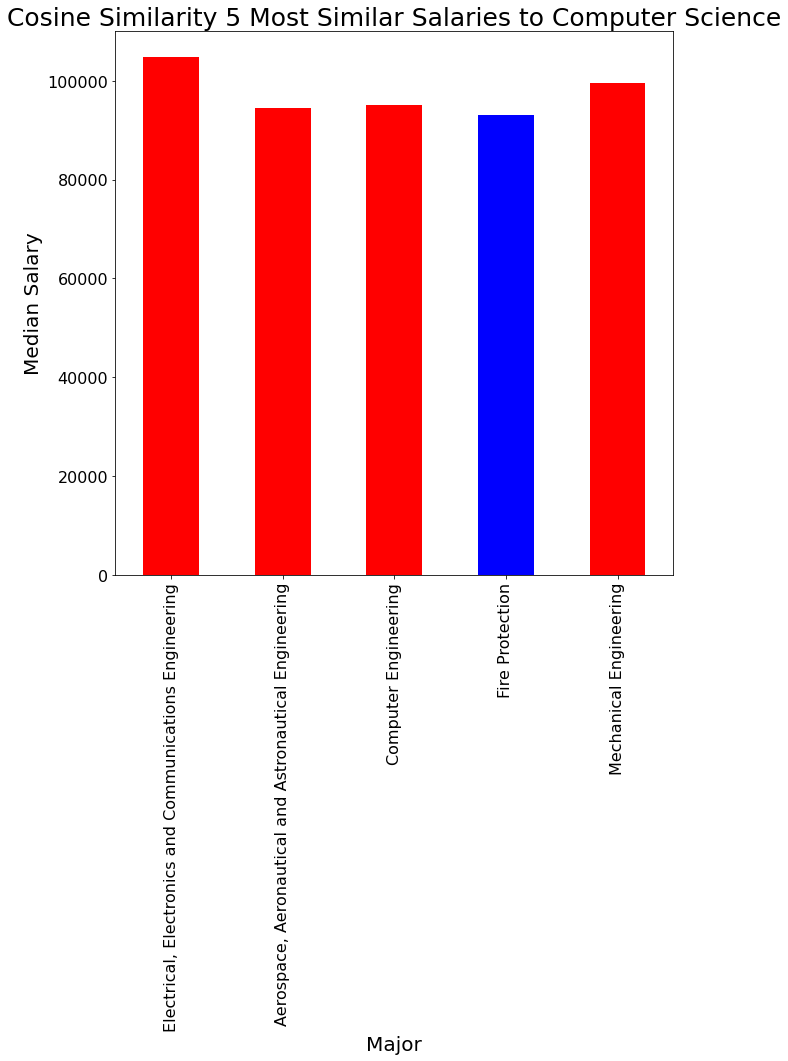

In [25]:
# Plotting the Recommended based on the two distances
ax = skrecs2.plot.bar(x='Field of Study\xa0',  y='Median Salary', title = 'Cosine Similarity 5 Most Similar Salaries to Computer Science', color=['red','red','red','blue','red'], legend=False, ylabel='Median Salary',fontsize=16, figsize=(10,10))
ax.set_xlabel('Major', fontsize=20)
ax.set_ylabel('Median Salary', fontsize=20)   # relative to plt.rcParams['font.size']
ax.set_title('Cosine Similarity 5 Most Similar Salaries to Computer Science', fontsize = 25)


Text(0.5, 1.0, 'Euclidean Distance 5 Most Similar Salaries to Computer Science')

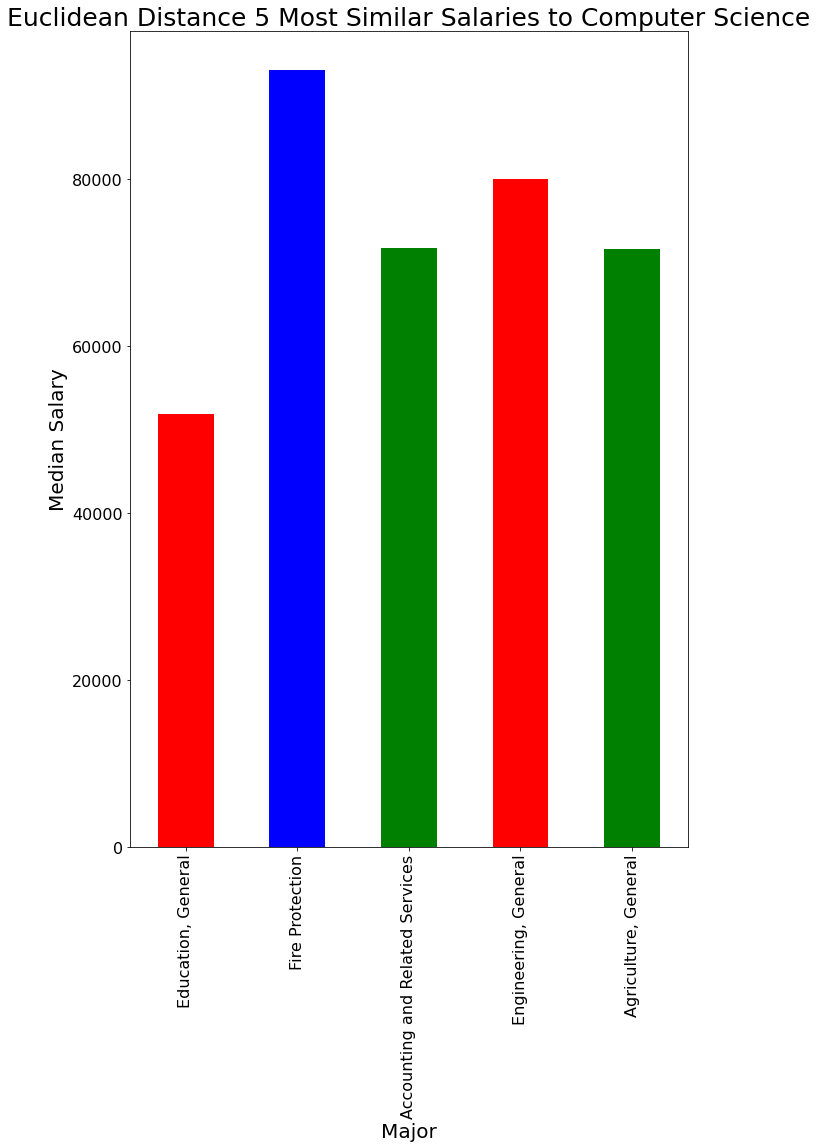

In [26]:
ax = eurecs2.plot.bar(x='Field of Study\xa0', y='Median Salary', color=['red','blue','green','red','green'], legend=False, fontsize=16, figsize=(10,15))
ax.set_xlabel('Major', fontsize=20)
ax.set_ylabel('Median Salary', fontsize=20)   # relative to plt.rcParams['font.size']
ax.set_title('Euclidean Distance 5 Most Similar Salaries to Computer Science', fontsize = 25)


Functioning on the false assumption that houses cost similarly now to how they did in 2008 for when the mid-career salary data was collected, we now aim to use the salary data to see what kind of housing is feasible for computer science majors dependent on whether they are at mid-career having graduated in the late 90s, or if they are recent grads.

As a reminder, we added a column to the housing dataset with the average mortgage in the state that which the house is being sold. This may not be 100% accurate, but using the averages may give an loose perspective on what one can expect to say.

Sources:<br>
https://www.bankrate.com/mortgages/average-monthly-mortgage-payment/#region

https://www.chase.com/personal/mortgage/education/financing-a-home/what-percentage-income-towards-mortgage#:~:text=The%2028%25%20rule%20states%20that,monthly%20gross%20income%20by%2028%25.

In [27]:
ec_df = df_major_salary2
ec_df
x = ec_df.iloc[16]

In [28]:
x2008 = df_degrees_over_career.iloc[13]

In [29]:
df_now = df_homes[df_homes['Average Mortgage'] <= (x['Median Salary']*.28)/12]
len(df_now)/len(df_homes)

0.9999838179846918

In [30]:
df_then = df_homes[df_homes['Average Mortgage'] <= (x2008['Mid-Career Median Salary']*.28)/12]
len(df_then)/len(df_homes)

0.9999838179846918

In [31]:
# df_desc = df_then.describe().rename(columns={"Average Mortgage": "a"
# df_desc['Now'] = df_now.describe()
# df_desc
pd.set_option('float_format', '{:.2f}'.format)
dfcs = pd.DataFrame(df_then['zestimate'].astype(float).describe())
dfcs = dfcs.rename(columns={"zestimate": "Then"})
dfcs['Now'] = df_now['zestimate'].astype(float).describe()
dfcs

,Then,Now
count,61796.00,61796.00
mean,775338.39,775338.39
std,2119185.27,2119185.27
min,10400.00,10400.00
25%,247100.00,247100.00
50%,406100.00,406100.00
75%,720500.00,720500.00
max,143537900.00,143537900.00


In [32]:
df_then['State'].value_counts()

Texas                   13354
California              11357
Florida                  4958
Georgia                  2211
Louisiana                2152
New York                 1858
Arizona                  1739
Pennsylvania             1736
Kentucky                 1580
Oregon                   1524
Illinois                 1489
North Carolina           1378
Washington               1349
Nevada                   1307
Michigan                 1291
Missouri                 1090
Nebraska                  968
Wisconsin                 959
Ohio                      944
Minnesota                 846
Alabama                   819
Colorado                  707
Oklahoma                  676
District of Columbia      565
Massachusetts             544
Maryland                  532
New Jersey                465
Wyoming                   447
Iowa                      443
Arkansas                  416
Mississippi               321
Idaho                     296
Kansas                    250
Indiana   

In [33]:
df_now['State'].value_counts()

Texas                   13354
California              11357
Florida                  4958
Georgia                  2211
Louisiana                2152
New York                 1858
Arizona                  1739
Pennsylvania             1736
Kentucky                 1580
Oregon                   1524
Illinois                 1489
North Carolina           1378
Washington               1349
Nevada                   1307
Michigan                 1291
Missouri                 1090
Nebraska                  968
Wisconsin                 959
Ohio                      944
Minnesota                 846
Alabama                   819
Colorado                  707
Oklahoma                  676
District of Columbia      565
Massachusetts             544
Maryland                  532
New Jersey                465
Wyoming                   447
Iowa                      443
Arkansas                  416
Mississippi               321
Idaho                     296
Kansas                    250
Indiana   

Using Chase's recommendation that "you should spend 28% or less of your monthly gross income on your mortgage payment", all homes in the housing dataset had a mortage within a payable rate with either salary. <br><br>

What about a different major? Psychology:

In [34]:
ec_df = df_major_salary2
ec_df
x = ec_df.iloc[66]

In [35]:
x2008 = df_degrees_over_career.loc['Psychology']

In [36]:
df_now = df_homes[df_homes['Average Mortgage'] <= (x['Median Salary']*.28)/12]
len(df_now)/len(df_homes)

0.04720293865397997

In [37]:
df_then = df_homes[df_homes['Average Mortgage'] <= (x2008['Mid-Career Median Salary']*.28)/12]
len(df_then)/len(df_homes)

0.6115345405116753

In [38]:
pd.set_option('float_format', '{:.2f}'.format)
dfp = pd.DataFrame(df_then['zestimate'].astype(float).describe())
dfp = dfcs.rename(columns={"zestimate": "Then"})
dfp['Now'] = df_now['zestimate'].astype(float).describe()
dfp

,Then,Now
count,61796.00,2917.00
mean,775338.39,323573.91
std,2119185.27,366341.89
min,10400.00,20600.00
25%,247100.00,153500.00
50%,406100.00,246900.00
75%,720500.00,370500.00
max,143537900.00,8367900.00


In [39]:
df_then['State'].value_counts()

Texas                   13354
Florida                  4958
Georgia                  2211
Louisiana                2152
Kentucky                 1580
Illinois                 1489
North Carolina           1378
Michigan                 1291
Missouri                 1090
Nebraska                  968
Wisconsin                 959
Ohio                      944
Minnesota                 846
Alabama                   819
Oklahoma                  676
District of Columbia      565
Maryland                  532
Iowa                      443
Arkansas                  416
Mississippi               321
Kansas                    250
Indiana                   244
Tennessee                 197
Virginia                   93
South Dakota               14
South Carolina              1
Name: State, dtype: int64

In [40]:
df_now['State'].value_counts()

Kentucky       1580
Alabama         819
Mississippi     321
Tennessee       197
Name: State, dtype: int64

Unexpectedly, the median career salary for a Psychology major in early 2010s is making more than recent Cal Poly Psychology majors, which means that people who graduated in that major prior were able to afford more houses than they would if graduating now. And since we know that housing was definitely more expensive, we may have reason to believe that this data can offer some insights on preferable majors if being a homeowner is valuable to someone.

What if someone is majoring in teaching? Can they afford a house?

In [41]:
ec_df = df_major_salary2
ec_df
x = ec_df.iloc[50]

In [42]:
x2008 = df_degrees_over_career.loc['Education']

In [43]:
df_now = df_homes[df_homes['Average Mortgage'] <= (x['Median Salary']*.28)/12]
len(df_now)/len(df_homes)

0.0

In [44]:
df_then = df_homes[df_homes['Average Mortgage'] <= (x2008['Mid-Career Median Salary']*.28)/12]
len(df_then)/len(df_homes)

0.18536498535527615

In [45]:
pd.set_option('float_format', '{:.2f}'.format)
dfe = pd.DataFrame(df_then['zestimate'].astype(float).describe())
dfe = dfcs.rename(columns={"zestimate": "Then"})
dfe['Now'] = df_now['zestimate'].astype(float).describe()
dfe

,Then,Now
count,61796.00,0.00
mean,775338.39,NaN
std,2119185.27,NaN
min,10400.00,NaN
25%,247100.00,NaN
50%,406100.00,NaN
75%,720500.00,NaN
max,143537900.00,NaN


In [46]:
df_now['State'].value_counts()

Series([], Name: State, dtype: int64)

In [47]:
df_then['State'].value_counts()

Kentucky        1580
Illinois        1489
Michigan        1291
Missouri        1090
Nebraska         968
Wisconsin        959
Ohio             944
Minnesota        846
Alabama          819
Iowa             443
Mississippi      321
Kansas           250
Indiana          244
Tennessee        197
South Dakota      14
Name: State, dtype: int64

Unlike Psycology, this one was not surpising at all...

Some visualizations for timeline salary expectations. The dataset with starting a mid career salaries offered a statistic for percent change in salary. Here is a box and whisker plot to get a picture of the sample.

<AxesSubplot:>

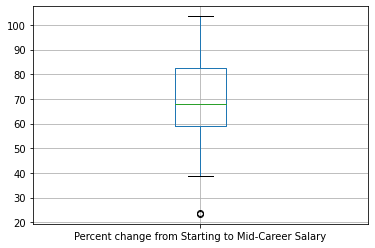

In [94]:

b = pd.DataFrame(df_percents).boxplot() 
b

In [98]:
per = pd.DataFrame(df_percents)
per.describe()

,Percent change from Starting to Mid-Career Salary
count,50.00
mean,69.27
std,17.91
min,23.40
25%,59.12
50%,67.80
75%,82.42
max,103.50


In [99]:
per[per['Percent change from Starting to Mid-Career Salary'] == 103.5]

,Percent change from Starting to Mid-Career Salary
Undergraduate Major,
Math,103.50
Philosophy,103.50


In [100]:
per[per['Percent change from Starting to Mid-Career Salary'] == 23.4]

,Percent change from Starting to Mid-Career Salary
Undergraduate Major,
Physician Assistant,23.40


This statistics offer insight into the majors with the largest growth potential and the lowest, being Math/Philosophy and Physiscian Assistant respectively.

According to The Balance, a financial resource website, the average annual pay raise depends on several factors. But in general, according to the U.S. Bureau of Labor Statistics, average compensation in the U.S. increased in 2022 by around 4.6%:

5.1% for civilian workers
5.5% in private industry
3.4% in state and local government

Using this average, what trends do we see with per major home affordability?


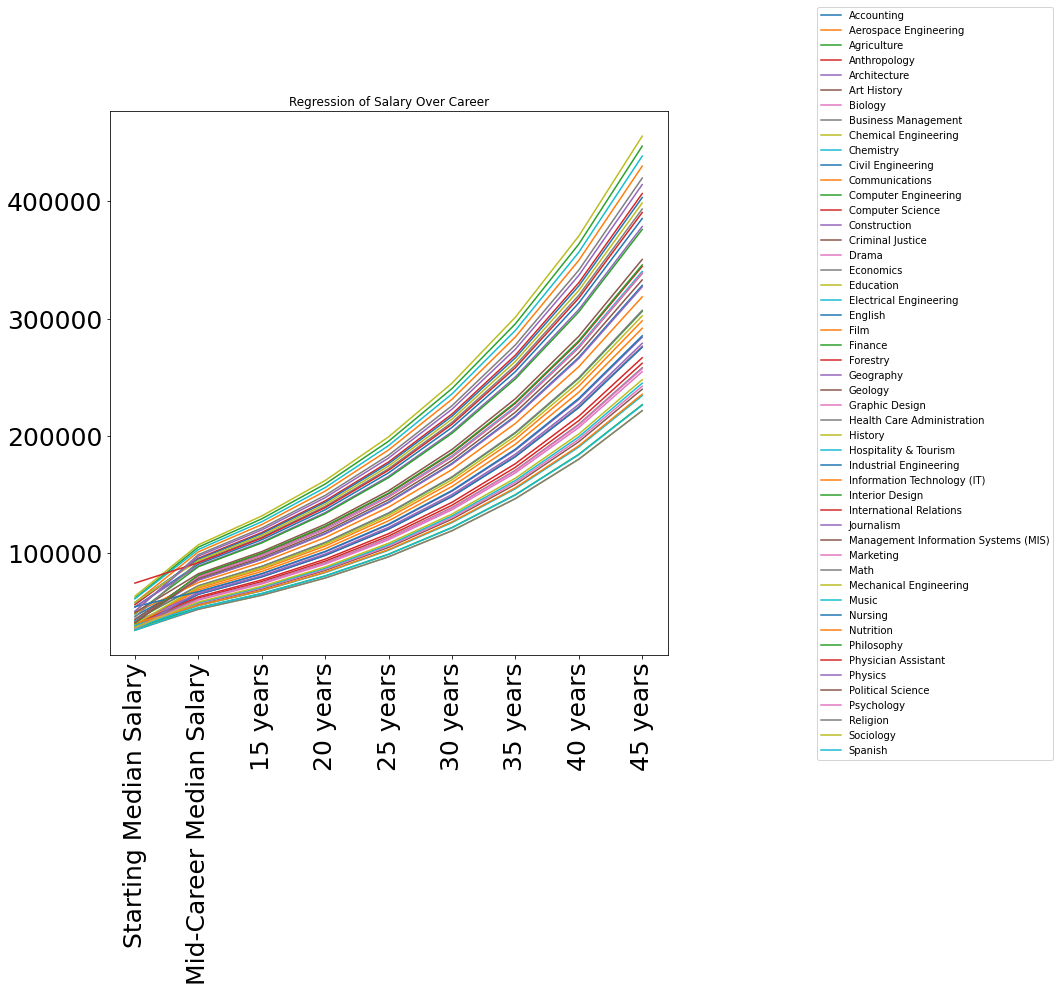

In [117]:
df_degrees_over_career['15 years'] = df_degrees_over_career['Mid-Career Median Salary']*(1+(.046*5))
df_degrees_over_career['20 years'] = df_degrees_over_career['15 years']*(1+(.046*5))
df_degrees_over_career['25 years'] = df_degrees_over_career['20 years']*(1+(.046*5))
df_degrees_over_career['30 years'] = df_degrees_over_career['25 years']*(1+(.046*5))
df_degrees_over_career['35 years'] = df_degrees_over_career['30 years']*(1+(.046*5))
df_degrees_over_career['40 years'] = df_degrees_over_career['35 years']*(1+(.046*5))
df_degrees_over_career['45 years'] = df_degrees_over_career['40 years']*(1+(.046*5))
df_degrees_over_career.T.plot(title = 'Regression of Salary Over Career', fontsize = 25, rot=90, figsize = (10,10)).legend(loc='center right',bbox_to_anchor=(1.7, 0.5));

In [125]:
df_degrees_over_career

,Starting Median Salary,Mid-Career Median Salary,15 years,20 years,25 years,30 years,35 years,40 years,45 years
Undergraduate Major,,,,,,,,,
Accounting,46000.00,77100.00,94833.00,116644.59,143472.85,176471.60,217060.07,266983.88,328390.18
Aerospace Engineering,57700.00,101000.00,124230.00,152802.90,187947.57,231175.51,284345.87,349745.43,430186.87
Agriculture,42600.00,71900.00,88437.00,108777.51,133796.34,164569.49,202420.48,248977.19,306241.94
Anthropology,36800.00,61500.00,75645.00,93043.35,114443.32,140765.28,173141.30,212963.80,261945.47
Architecture,41600.00,76800.00,94464.00,116190.72,142914.59,175784.94,216215.48,265945.04,327112.39
Art History,35800.00,64900.00,79827.00,98187.21,120770.27,148547.43,182713.34,224737.41,276427.01
Biology,38800.00,64800.00,79704.00,98035.92,120584.18,148318.54,182431.81,224391.12,276001.08
Business Management,43000.00,72100.00,88683.00,109080.09,134168.51,165027.27,202983.54,249669.75,307093.80
Chemical Engineering,63200.00,107000.00,131610.00,161880.30,199112.77,244908.71,301237.71,370522.38,455742.53


<AxesSubplot:title={'center':'Percentage of Homes A Major Could Afford Over Career'}>

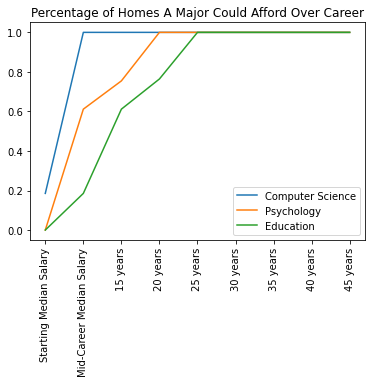

In [145]:
percent = []
majors = ['Computer Science','Psychology','Education']

for maj in majors:
    u = []
    for col in df_degrees_over_career:
        u.append(len(df_homes[df_homes['Average Mortgage'] <= (df_degrees_over_career.loc[maj][col]*.28)/12])/len(df_homes))
    percent.append(u)
    
p = pd.DataFrame(percent, index = majors)
p.columns = list(df_degrees_over_career)
p.T.plot(title='Percentage of Homes A Major Could Afford Over Career',rot = 90)

Without considering possibilities of recession, unemployment, or lay offs, and assuming consistent and persistent salary growth, Computer Science majors are able to afford nearly 100% of homes within 10 years of work. Psycology can afford 100% around 20 years after graduation, which makes sense if we consider that many Psycology majors also pursue Masters degrees, so their pay boost will take longer. Teachers approach the full 100% at around 25 years after graduation.

What these statistics are getting at is the intense discrepency between affordability between majors. If some majors can afford all the homes within 10 years of graduation, the projection of home purchasing timeline for the other majors with change and ebb with market availability. If those 10 year majors buy up 2022 homes, supply goes down and costs go up. Now that 20 year timeline may shift to 30 years, furthering the diving in housing affordability, which may lead to irrevicoble social class dynamics.

## Clustering

### Clustering living wage

#### Using Sklearn library

In [48]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(living_wage_by_major),columns=living_wage_by_major.columns)
X

,population_2020,population_2010,land_area_sqmi,density,one_adult_no_kids_living_wage,one_adult_one_kid_living_wage,one_adult_two_kids_living_wage,one_adult_three_kids_living_wage,two_adults_one_working_no_kids_living_wage,two_adults_one_working_one_kid_living_wage,two_adults_one_working_two_kids_living_wage,two_adults_one_working_three_kids_living_wage,two_adults_both_working_no_kids_living_wage,two_adults_both_working_one_kid_living_wage,two_adults_both_working_two_kids_living_wage,two_adults_both_working_three_kids_living_wage,med-hourly
0,9.55,9.46,0.54,6.58,1.97,1.54,1.64,1.57,1.44,1.25,1.24,1.14,1.38,1.52,1.62,1.58,1.16
1,9.55,9.46,0.54,6.58,1.97,1.54,1.64,1.57,1.44,1.25,1.24,1.14,1.38,1.52,1.62,1.58,0.06
2,9.55,9.46,0.54,6.58,1.97,1.54,1.64,1.57,1.44,1.25,1.24,1.14,1.38,1.52,1.62,1.58,0.44
3,9.55,9.46,0.54,6.58,1.97,1.54,1.64,1.57,1.44,1.25,1.24,1.14,1.38,1.52,1.62,1.58,-0.30
4,9.55,9.46,0.54,6.58,1.97,1.54,1.64,1.57,1.44,1.25,1.24,1.14,1.38,1.52,1.62,1.58,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,-0.46,-0.45,-0.59,-0.18,0.23,-0.20,-0.24,-0.30,-0.12,-0.16,-0.16,-0.25,0.04,-0.21,-0.24,-0.31,-1.10
4433,-0.46,-0.45,-0.59,-0.18,0.23,-0.20,-0.24,-0.30,-0.12,-0.16,-0.16,-0.25,0.04,-0.21,-0.24,-0.31,-0.27
4434,-0.46,-0.45,-0.59,-0.18,0.23,-0.20,-0.24,-0.30,-0.12,-0.16,-0.16,-0.25,0.04,-0.21,-0.24,-0.31,-0.93
4435,-0.46,-0.45,-0.59,-0.18,0.23,-0.20,-0.24,-0.30,-0.12,-0.16,-0.16,-0.25,0.04,-0.21,-0.24,-0.31,-0.39


In [49]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
display(X_pca)
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);

,0,1
0,7.39,13.85
1,7.32,13.85
2,7.34,13.85
3,7.30,13.85
4,7.36,13.85
...,...,...
4432,-0.67,-0.70
4433,-0.62,-0.70
4434,-0.66,-0.70
4435,-0.63,-0.70


In [50]:
kmeans = KMeans(n_clusters=3).fit(X)
cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

<AxesSubplot:xlabel='PCA Component 0', ylabel='PCA Component 1'>

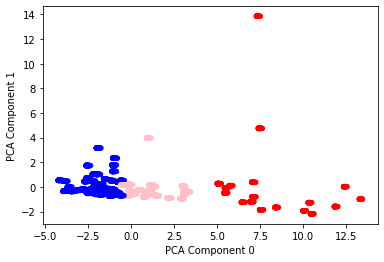

In [51]:
colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[2])
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3], xlabel='PCA Component 0', ylabel='PCA Component 1')

In [52]:
silhouette_score(X, cluster_labels[3])

0.30941564936415966

In [53]:
s_df = pd.DataFrame()

s_df[3] = silhouette_samples(X, cluster_labels[3])
s_df.index.name="i"
s_df = s_df.reset_index()
# display(s_df)
# s_df.sort_values(by=[3]).plot(kind='hist')

source = s_df.melt(id_vars=["i"])
source.columns = ["i","k","s"]
# display(source)

# alt.renderers.enable('mimetype')
alt.renderers.enable('default')
alt.Chart(source).mark_bar().encode(
    x = "s:Q",
    y = alt.Y("i:N",sort='x',axis=alt.Axis(labels=False)),
    row = "k:N",
    color = "k:N"
).resolve_scale(y='independent').properties(height=200)

# alt.Chart(s.reset_index()).mark_line().encode(
#     x='index:T',
#     y='sil:Q'
# )


alt.Chart(...)

In [54]:
df = living_wage_by_major.reset_index()[['city','state','field-study']]
df['label']  = cluster_labels[3]
df['label'].value_counts()

0    2878
2    1012
1     547
Name: label, dtype: int64

Let's see what cities have which majors:

In [55]:
for cluster in sorted(df['label'].unique()):
    print(cluster)
    # display(df[df['label'] == cluster].head())
    # df[df['label'] == cluster].to_csv(f'out_cluster_{cluster}.csv')
    display(df[df['label'] == cluster].groupby(['state', 'city'])['label'].value_counts())


0


state           city             label
Alaska          Anchorage        0        47
Arizona         Chandler         0        45
                Gilbert          0        45
                Glendale         0        45
                Mesa             0        46
                Phoenix          0        46
                Scottsdale       0        46
                Tucson           0        50
Florida         Jacksonville     0        51
                Orlando          0        46
                St. Petersburg   0        46
                Tampa            0        46
Idaho           Boise            0        50
Indiana         Fort Wayne       0        51
                Indianapolis     0        50
Kansas          Wichita          0        51
Kentucky        Lexington        0        50
                Louisville       0        50
Louisiana       Baton Rouge      0        50
                New Orleans      0        47
Missouri        Kansas City      0        50
                

1


state                 city           label
California            Anaheim        1        35
                      Chula Vista    1        29
                      Fremont        1        27
                      Irvine         1        27
                      Long Beach     1        35
                      Los Angeles    1        35
                      Oakland        1        26
                      San Diego      1        34
                      San Francisco  1        26
                      San Jose       1        21
                      Santa Ana      1        27
                      Santa Clarita  1        35
District of Columbia  Washington     1        32
Hawaii                Honolulu       1        30
Massachusetts         Boston         1        35
New Jersey            Jersey City    1        31
                      Newark         1        31
New York              New York       1        31
Name: label, dtype: int64

2


state           city              label
California      Bakersfield       2        50
                Fresno            2        50
                Riverside         2        45
                Sacramento        2        42
                Stockton          2        47
Colorado        Aurora            2        39
                Colorado Springs  2        48
                Denver            2        39
Florida         Miami             2        44
Georgia         Atlanta           2        42
Illinois        Chicago           2        42
Maryland        Baltimore         2        45
Michigan        Detroit           2        50
Minnesota       Minneapolis       2        45
                Saint Paul        2        45
North Carolina  Durham            2         2
                Raleigh           2        42
Oregon          Portland          2        36
Virginia        Chesapeake        2        42
                Norfolk           2        42
                Virginia Beach    2     

#### From scratch kmeans

In [56]:
distortions = []
k = 3
means = X.sample(n=k)
last_distortion = np.Inf
while True:
    # Assignment to a cluster
    clusters = []
    distortion = 0
    for i in range(len(X)):
        x = X.iloc[i]
        min_d = np.Inf
        min_c = None
        for j in range(len(means)):
            c = means.iloc[j]
            d = Project_helper.distance(x, c)
            if d < min_d:
                min_c = j
                min_d = d
        distortion += np.dot((x - means.iloc[j]), (x - means.iloc[j]))
        clusters.append(min_c)
    Xc = X.copy()
    Xc['cluster'] = clusters
    distortions.append(distortion)
    # Distortion should go down over time, and eventually slow down
    if np.abs(distortion - last_distortion) < 0.000001:
        break
    last_distortion = distortion
    print(distortion)
    means = Xc.groupby('cluster').mean()

118801.55297803644
89120.37136804321
85391.14854573329
82096.80487259092
79436.46840893094
77173.0519391631
76426.56340781791
76595.72437102384
76677.02273907996
76682.10497193401
76632.06702613796
76624.21631577179
76629.26469139816
76631.36495807182
76635.45993163512
76639.56348080095
76649.14870953228
76653.6770812778
76655.95235599179


<AxesSubplot:xlabel='PCA Component 0', ylabel='PCA Component 1'>

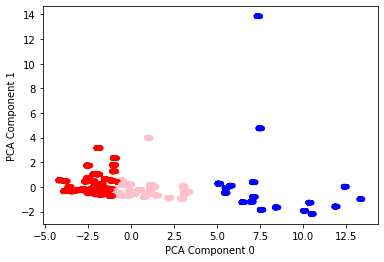

In [57]:
cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = clusters
cluster_labels = pd.DataFrame(cluster_labels)

colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink", 3: 'Green'}) # This is a new pandas command for us that maps all 0 values to Blue, etc
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3], xlabel='PCA Component 0', ylabel='PCA Component 1')

### Clustering by long-term livability of a city

#### Using Sklearn

<AxesSubplot:xlabel='PCA Component 0', ylabel='PCA Component 1'>

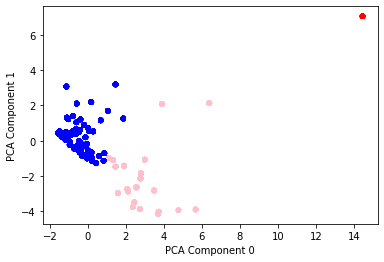

In [58]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(living_wage_over_time),columns=living_wage_over_time.columns)
# display(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
# display(X_pca)
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);
kmeans = KMeans(n_clusters=3).fit(X)

cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink", 3: 'Green'}) # This is a new pandas command for us that maps all 0 values to Blue, etc
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3], xlabel='PCA Component 0', ylabel='PCA Component 1')

In [59]:
#from sklearn.metrics import silhouette_samples

s_df = pd.DataFrame()

s_df[3] = silhouette_samples(X, cluster_labels[3])
s_df.index.name="i"
s_df = s_df.reset_index()
# display(s_df)
# s_df.sort_values(by=[3]).plot(kind='hist')

source = s_df.melt(id_vars=["i"])
source.columns = ["i","k","s"]
# display(source)

import altair as alt
# alt.renderers.enable('mimetype')
alt.renderers.enable('default')
alt.Chart(source).mark_bar().encode(
    x = "s:Q",
    y = alt.Y("i:N",sort='x',axis=alt.Axis(labels=False)),
    row = "k:N",
    color = "k:N"
).resolve_scale(y='independent').properties(height=200)

# alt.Chart(s.reset_index()).mark_line().encode(
#     x='index:T',
#     y='sil:Q'
# )


alt.Chart(...)

In [60]:
silhouette_score(X, cluster_labels[3])

0.580418638073979

What majors can afford each cluster:

In [61]:
df = living_wage_over_time.reset_index()
df['label'] = cluster_labels[3]
df['label'].value_counts()

for cluster in sorted(df['label'].unique()):
    print(cluster)
    sets = df[df['label'] == cluster].groupby(['state', 'city'])['Undergraduate Major'].apply(set)
    output = list(set.intersection(*(list(sets))))
    print("Number of majors:", len(output))
    display(pd.Series(output))



0
Number of majors: 28


0                     Computer Engineering
1                             Architecture
2                         Computer Science
3                                  Physics
4                           Communications
5                                  Finance
6                               Philosophy
7     Management Information Systems (MIS)
8                                  Geology
9                    Aerospace Engineering
10                               Chemistry
11                               Economics
12             Information Technology (IT)
13                 International Relations
14                       Political Science
15                     Business Management
16                     Physician Assistant
17                             Agriculture
18                    Chemical Engineering
19                               Marketing
20                                 History
21                       Civil Engineering
22                  Mechanical Engineering
23         

1
Number of majors: 21


0                              Agriculture
1                     Chemical Engineering
2                     Computer Engineering
3                         Computer Science
4                                  Physics
5                                  Finance
6     Management Information Systems (MIS)
7                        Civil Engineering
8                   Mechanical Engineering
9                                  Geology
10                              Accounting
11                   Aerospace Engineering
12                               Chemistry
13                               Economics
14             Information Technology (IT)
15                            Construction
16                                    Math
17                  Electrical Engineering
18                  Industrial Engineering
19                     Business Management
20                     Physician Assistant
dtype: object

2
Number of majors: 7


0     Aerospace Engineering
1      Chemical Engineering
2      Computer Engineering
3          Computer Science
4    Electrical Engineering
5    Mechanical Engineering
6    Industrial Engineering
dtype: object

#### Kmeans from scratch
Can re-use scaler, X, and PCA from the sklearn version

NOTE: flip side of that is that one needs to run some of sklearn cells first for these cells to work

In [62]:
distortions = []
k = 3
means = X.sample(n=k)
last_distortion = np.Inf
while True:
    # Assignment to a cluster
    clusters = []
    distortion = 0
    for i in range(len(X)):
        x = X.iloc[i]
        min_d = np.Inf
        min_c = None
        for j in range(len(means)):
            c = means.iloc[j]
            d = Project_helper.distance(x, c)
            if d < min_d:
                min_c = j
                min_d = d
        distortion += np.dot((x - means.iloc[j]), (x - means.iloc[j]))
        clusters.append(min_c)
    Xc = X.copy()
    Xc['cluster'] = clusters
    distortions.append(distortion)
    # Distortion should go down over time, and eventually slow down
    if np.abs(distortion - last_distortion) < 0.000001:
        break
    last_distortion = distortion
    print(distortion)
    means = Xc.groupby('cluster').mean()

26797.528193689755
29454.771429957276
36541.381628820614
46102.32902353235
53487.52667537923
56742.5172172785
59795.90673634778
63170.004200470365


<AxesSubplot:xlabel='PCA Component 0', ylabel='PCA Component 1'>

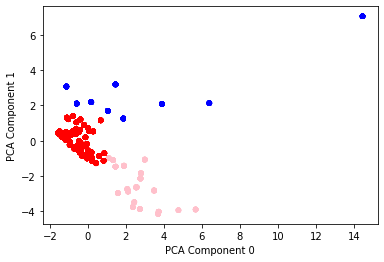

In [63]:
cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = clusters
cluster_labels = pd.DataFrame(cluster_labels)

colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink", 3: 'Green'}) # This is a new pandas command for us that maps all 0 values to Blue, etc
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3], xlabel='PCA Component 0', ylabel='PCA Component 1')

### Clustering majors by salary

#### With Sklearn

<AxesSubplot:xlabel='PCA Component 0', ylabel='PCA Component 1'>

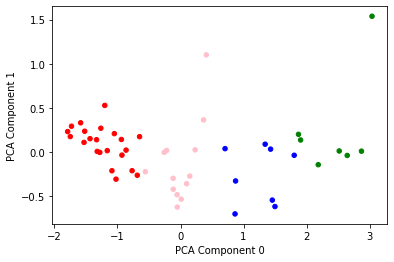

In [64]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_degrees_over_career),columns=df_degrees_over_career.columns)
X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
# display(X_pca)
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1]);
kmeans = KMeans(n_clusters=4).fit(X)

cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = kmeans.predict(X)
cluster_labels = pd.DataFrame(cluster_labels)

colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink", 3: 'Green'}) # This is a new pandas command for us that maps all 0 values to Blue, etc
# X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[2])
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3], xlabel='PCA Component 0', ylabel='PCA Component 1')

In [65]:
# df = X.reset_index()
df = df_degrees_over_career.reset_index()
df['label'] = cluster_labels[3]
df['label'].value_counts()

1    22
2    13
0     8
3     7
Name: label, dtype: int64

In [66]:
for cluster in sorted(df['label'].unique()):
    # print(cluster)
    display(df[df['label'] == cluster].sample(frac = 1).head(3))
    # display(df[df['label'] == cluster])

,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
10,Civil Engineering,53900.00,90500.00,0
22,Finance,47900.00,88300.00,0
37,Math,45400.00,92400.00,0


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
48,Sociology,36500.00,58200.00,1
16,Drama,35900.00,56900.00,1
21,Film,37900.00,68500.00,1


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
45,Political Science,40800.00,78200.00,2
0,Accounting,46000.00,77100.00,2
2,Agriculture,42600.00,71900.00,2


,Undergraduate Major,Starting Median Salary,Mid-Career Median Salary,label
43,Physician Assistant,74300.00,91700.00,3
1,Aerospace Engineering,57700.00,101000.00,3
8,Chemical Engineering,63200.00,107000.00,3


#### From scratch kmeans

In [67]:
distortions = []
k = 4
means = X.sample(n=k)
last_distortion = np.Inf
while True:
    # Assignment to a cluster
    clusters = []
    distortion = 0
    for i in range(len(X)):
        x = X.iloc[i]
        min_d = np.Inf
        min_c = None
        for j in range(len(means)):
            c = means.iloc[j]
            d = Project_helper.distance(x, c)
            if d < min_d:
                min_c = j
                min_d = d
        distortion += np.dot((x - means.iloc[j]), (x - means.iloc[j]))
        clusters.append(min_c)
    Xc = X.copy()
    Xc['cluster'] = clusters
    distortions.append(distortion)
    # Distortion should go down over time, and eventually slow down
    if np.abs(distortion - last_distortion) < 0.000001:
        break
    last_distortion = distortion
    print(distortion)
    means = Xc.groupby('cluster').mean()

512.320306538616
566.724511928039


<AxesSubplot:xlabel='PCA Component 0', ylabel='PCA Component 1'>

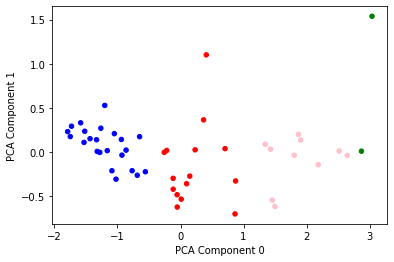

In [68]:
cluster_labels = {}
# Are we doing 1 indexing now?
cluster_labels[3] = clusters
cluster_labels = pd.DataFrame(cluster_labels)

colorings = {}
# colorings[2] = cluster_labels[2].map({0: "Blue", 1: "Red"}) # This is a new pandas command for us that maps all 0 values to Blue, etc
colorings[3] = cluster_labels[3].map({0: "Blue", 1: "Red",2: "Pink", 3: 'Green'}) # This is a new pandas command for us that maps all 0 values to Blue, etc
X_pca.plot.scatter(x=X_pca.columns[0],y=X_pca.columns[1],c=colorings[3], xlabel='PCA Component 0', ylabel='PCA Component 1')